<a href="https://colab.research.google.com/github/Rezarsa82/online_retail_matrix_monitoring/blob/main/OnlineRetail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import zipfile
import requests
from io import BytesIO

url = "https://archive.ics.uci.edu/static/public/352/online+retail.zip"

r = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(r.content))

print(zip_file.namelist())  # ['Online Retail.xlsx']

excel_file = zip_file.open("Online Retail.xlsx")
df = pd.read_excel(excel_file)

print(df.columns)
print(df.head())

['Online Retail.xlsx']
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [2]:
print(df.isna().sum())
df = df.dropna()
print(df.isna().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [3]:
df = df[df["Quantity"] > 0]
print((df["Quantity"] <= 0).sum())
num_cancelled = df[df["InvoiceNo"].astype(str).str.startswith("C")].shape[0]
print("Cannelled:", num_cancelled)
df_sorted = df.sort_values('InvoiceDate')

0
Cannelled: 0


In [4]:
item_transaction_matrix = df_sorted.groupby(['InvoiceNo', 'StockCode'])['Quantity'].sum().unstack().fillna(0)

item_transaction_matrix[item_transaction_matrix > 0] = 1

print(item_transaction_matrix.head())

StockCode  10002  10080  10120  10125  10133  10135  11001  15030  15034  \
InvoiceNo                                                                  
536365       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
536366       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
536367       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
536368       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
536369       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

StockCode  15036  ...  90214V  90214W  90214Y  90214Z  BANK CHARGES   C2  DOT  \
InvoiceNo         ...                                                           
536365       0.0  ...     0.0     0.0     0.0     0.0           0.0  0.0  0.0   
536366       0.0  ...     0.0     0.0     0.0     0.0           0.0  0.0  0.0   
536367       0.0  ...     0.0     0.0     0.0     0.0           0.0  0.0  0.0   
536368       0.0  ...     0.0     0.0     0.0     0.0         

In [5]:
import random

random_invoices = random.sample(list(item_transaction_matrix.index), 5)

for invoice in random_invoices:
    purchased_items = item_transaction_matrix.loc[invoice][item_transaction_matrix.loc[invoice] == 1]
    print(f"ّInvoice {invoice}: {len(purchased_items)} Products")
    if len(purchased_items) > 0:
        print(f"   Products: {list(purchased_items.index[:5])}")

ّInvoice 562599: 10 Products
   Products: [22361, 22362, 22962, 22963, 23012]
ّInvoice 563907: 7 Products
   Products: [22169, 22720, 23298, 47566, 71477]
ّInvoice 579099: 29 Products
   Products: [16046, 20674, 20675, 20677, 21034]
ّInvoice 564862: 1 Products
   Products: ['POST']
ّInvoice 555415: 4 Products
   Products: [21340, 22178, 22427, 22784]


In [24]:
batch_size = 1000
batches = []

for i in range(0, len(item_transaction_matrix), batch_size):
    batch_matrix = item_transaction_matrix.iloc[i : i + batch_size]
    batches.append(batch_matrix)

print(f"Total batches: {len(batches)}")
print(f"First batch shape: {batches[0].shape}")
print(f"Last batch shape: {batches[-1].shape}")

Total batches: 19
First batch shape: (1000, 3665)
Last batch shape: (536, 3665)


In [7]:
class FrequentDirections:
    def __init__(self, ell):
        self.ell = ell
        self.d = None
        self.sketch = None
        self.next_row = 0

    def fit(self, data_stream):
        for row in data_stream:
            self._update(row)

    def _is_full(self):
        return self.next_row >= self.ell

    def _update(self, row):
        row = np.array(row)

        if self.d is None:
            self.d = len(row)
            self.sketch = np.zeros((self.ell, self.d))
            self.next_row = 0

        if self._is_full():
            self._compress()

        self.sketch[self.next_row] = row
        self.next_row += 1

    def _compress(self):
        U, sigma, Vt = np.linalg.svd(self.sketch, full_matrices=False)

        delta_sq = sigma[self.ell // 2 - 1] ** 2

        new_sigma_sq = np.maximum(sigma ** 2 - delta_sq, 0)
        new_sigma = np.sqrt(new_sigma_sq)

        self.sketch = np.diag(new_sigma) @ Vt

        self.next_row = self.ell // 2

    def get_sketch(self):
        return self.sketch


In [8]:
import numpy as np

def test_fd_basic_shape():
    print("Test 1: Basic shape check")
    data = np.random.randn(100, 10)
    fd = FrequentDirections(ell=5)
    fd.fit(data)
    B = fd.get_sketch()

    assert B.shape == (5, 10), f"Expected (5, 10), got {B.shape}"
    print("✅ Passed: Output shape is correct.")


def test_fd_reduces_dimension():
    print("Test 2: Dimensionality reduction consistency")
    data = np.random.randn(200, 20)
    ell = 8
    fd = FrequentDirections(ell)
    fd.fit(data)
    B = fd.get_sketch()

    rank_B = np.linalg.matrix_rank(B)
    assert rank_B <= ell, f"Rank too high: {rank_B} > {ell}"
    print("✅ Passed: Sketch rank is within expected limit.")


def test_fd_variance_preservation():
    print("Test 3: Variance preservation (A^T A ≈ B^T B)")
    np.random.seed(0)
    data = np.random.randn(500, 50)
    ell = 20
    fd = FrequentDirections(ell)
    fd.fit(data)
    B = fd.get_sketch()

    A_cov = data.T @ data
    B_cov = B.T @ B
    diff = np.linalg.norm(A_cov - B_cov, 'fro')

    print(f"‣ Frobenius norm difference: {diff:.4f}")
    assert diff < np.linalg.norm(A_cov, 'fro'), "Sketch too inaccurate!"
    print("✅ Passed: Sketch preserves variance reasonably.")


def test_fd_on_stream():
    print("Test 4: Streaming consistency")
    np.random.seed(42)
    data = np.random.randn(1000, 30)
    fd = FrequentDirections(ell=15)

    for i in range(0, len(data), 10):
        fd.fit(data[i:i+10])

    B = fd.get_sketch()
    assert not np.allclose(B, 0), "Sketch should not be all zeros."
    print("✅ Passed: Streaming updates work correctly.")


def test_fd_repeatability():
    print("Test 5: Determinism")
    np.random.seed(123)
    data = np.random.randn(300, 20)
    ell = 10

    fd1 = FrequentDirections(ell)
    fd1.fit(data)
    B1 = fd1.get_sketch()

    fd2 = FrequentDirections(ell)
    fd2.fit(data)
    B2 = fd2.get_sketch()

    assert np.allclose(B1, B2), "Frequent Directions should be deterministic."
    print("✅ Passed: Algorithm is deterministic.")

def test_fd_theoretical_bound():
    print("Test 6: Theoretical FD guarantee check")

    np.random.seed(123)
    n, d = 500, 50
    ell = 20
    data = np.random.randn(n, d)

    fd = FrequentDirections(ell)
    fd.fit(data)
    B = fd.get_sketch()

    A_cov = data.T @ data
    B_cov = B.T @ B

    A_fro_sq = np.linalg.norm(data, 'fro') ** 2

    spectral_diff = np.linalg.norm(A_cov - B_cov, 2)

    bound = A_fro_sq / ell

    print(f"‣ Spectral diff: {spectral_diff:.4f}")
    print(f"‣ Theoretical bound: {bound:.4f}")

    assert spectral_diff <= bound * 1.2, (
        f"❌ Theoretical guarantee violated: diff={spectral_diff:.4f} > bound={bound:.4f}"
    )
    print("✅ Passed: Theoretical FD guarantee approximately holds.")

test_fd_basic_shape()
test_fd_reduces_dimension()
test_fd_variance_preservation()
test_fd_on_stream()
test_fd_repeatability()
test_fd_theoretical_bound()
print("\nAll tests passed successfully!")


Test 1: Basic shape check
✅ Passed: Output shape is correct.
Test 2: Dimensionality reduction consistency
✅ Passed: Sketch rank is within expected limit.
Test 3: Variance preservation (A^T A ≈ B^T B)
‣ Frobenius norm difference: 3525.2132
✅ Passed: Sketch preserves variance reasonably.
Test 4: Streaming consistency
✅ Passed: Streaming updates work correctly.
Test 5: Determinism
✅ Passed: Algorithm is deterministic.
Test 6: Theoretical FD guarantee check
‣ Spectral diff: 830.0659
‣ Theoretical bound: 1240.3073
✅ Passed: Theoretical FD guarantee approximately holds.

All tests passed successfully!


In [9]:
class IPCA:
    def __init__(self, n_components, amnesic=1.0, continuity_correction=True):
        self.n_components = n_components
        self.amnesic = amnesic
        self.continuity_correction = continuity_correction

        self.mean_ = None
        self.components_ = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None
        self.n_samples_seen_ = 0
        self.svd_ = None

    def fit(self, X, y=None):
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(1, -1)

        for i in range(X.shape[0]):
            self.partial_fit(X[i:i+1])
        return self

    def partial_fit(self, X):
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(1, -1)

        n_samples, n_features = X.shape

        if self.mean_ is None:
            self.mean_ = np.zeros(n_features)
            self.components_ = np.eye(n_features)[:self.n_components]
            self.explained_variance_ = np.zeros(self.n_components)
            self.svd_ = {
                'U': np.eye(n_features, self.n_components),
                'sigma': np.zeros(self.n_components),
                'Vt': np.eye(self.n_components, n_features)
            }

        old_mean = self.mean_.copy()
        self.mean_ = (self.n_samples_seen_ * self.mean_ + np.sum(X, axis=0)) / (self.n_samples_seen_ + n_samples)

        if self.continuity_correction and self.n_samples_seen_ > 0:
            correction = np.sqrt(self.n_samples_seen_ * n_samples / (self.n_samples_seen_ + n_samples)) * (old_mean - self.mean_)
            X_centered = X - self.mean_ + correction
        else:
            X_centered = X - self.mean_

        self._update_svd(X_centered)

        self.n_samples_seen_ += n_samples
        return self

    def _update_svd(self, X_centered):
        n_samples, n_features = X_centered.shape

        if self.n_samples_seen_ == 0:
            U, sigma, Vt = np.linalg.svd(X_centered, full_matrices=False)
            self.svd_ = {
                'U': U[:, :self.n_components],
                'sigma': sigma[:self.n_components],
                'Vt': Vt[:self.n_components]
            }
        else:
            U_old = self.svd_['U']
            sigma_old = self.svd_['sigma']
            Vt_old = self.svd_['Vt']

            if self.amnesic != 1.0 and self.n_samples_seen_ > 0:
                weight = (self.n_samples_seen_ / (self.n_samples_seen_ + n_samples)) ** self.amnesic
                sigma_old = sigma_old * weight

            augmented_matrix = np.vstack([
                np.diag(sigma_old) @ Vt_old,
                X_centered
            ])

            U_aug, sigma_aug, Vt_aug = np.linalg.svd(augmented_matrix, full_matrices=False)

            self.svd_ = {
                'U': U_aug[:, :self.n_components],
                'sigma': sigma_aug[:self.n_components],
                'Vt': Vt_aug[:self.n_components]
            }

        self.components_ = self.svd_['Vt']
        self.explained_variance_ = (self.svd_['sigma'] ** 2) / max(1, self.n_samples_seen_)

        total_variance = np.sum(self.explained_variance_)
        if total_variance > 0:
            self.explained_variance_ratio_ = self.explained_variance_ / total_variance
        else:
            self.explained_variance_ratio_ = self.explained_variance_

    def transform(self, X):
        if self.mean_ is not None:
            X_centered = X - self.mean_
            return X_centered @ self.components_.T
        else:
            return X

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        if self.mean_ is not None:
            return X @ self.components_ + self.mean_
        else:
            return X

    def get_sketch(self):
        return {
            'components': self.components_,
            'explained_variance': self.explained_variance_,
            'mean': self.mean_,
            'n_samples': self.n_samples_seen_
        }

In [10]:
def test_ipca_initialization():
    print("Test 1: Initialization check")
    ipca = IPCA(n_components=3)

    assert ipca.n_components == 3, f"Expected 3, got {ipca.n_components}"
    assert ipca.mean_ is None, "Mean should be None before fitting"
    assert ipca.components_ is None, "Components should be None before fitting"
    assert ipca.n_samples_seen_ == 0, f"Expected 0 samples, got {ipca.n_samples_seen_}"
    print("✅ Passed: Initialization is correct.")

def test_ipca_basic_shape():
    print("Test 2: Basic shape check after fitting")
    data = np.random.randn(100, 10)
    ipca = IPCA(n_components=5)
    ipca.fit(data)

    assert ipca.components_.shape == (5, 10), f"Expected (5, 10), got {ipca.components_.shape}"
    assert ipca.mean_.shape == (10,), f"Expected (10,), got {ipca.mean_.shape}"
    assert ipca.n_samples_seen_ == 100, f"Expected 100 samples, got {ipca.n_samples_seen_}"
    print("✅ Passed: Output shapes are correct.")

def test_ipca_transform_consistency():
    print("Test 3: Transform and inverse transform consistency")
    np.random.seed(42)
    data = np.random.randn(50, 8)
    ipca = IPCA(n_components=4)
    ipca.fit(data)

    X_transformed = ipca.transform(data)
    X_reconstructed = ipca.inverse_transform(X_transformed)

    assert X_transformed.shape == (50, 4), f"Expected (50, 4), got {X_transformed.shape}"
    assert X_reconstructed.shape == (50, 8), f"Expected (50, 8), got {X_reconstructed.shape}"

    reconstruction_error = np.mean((data - X_reconstructed) ** 2)
    print(f"‣ Reconstruction error: {reconstruction_error:.6f}")
    assert reconstruction_error < 1.0, "Reconstruction error too high!"
    print("✅ Passed: Transform and inverse transform work correctly.")

def test_ipca_orthogonality():
    print("Test 4: Components orthogonality check")
    data = np.random.randn(200, 15)
    ipca = IPCA(n_components=6)
    ipca.fit(data)

    dot_products = ipca.components_ @ ipca.components_.T
    identity_matrix = np.eye(6)

    max_deviation = np.max(np.abs(dot_products - identity_matrix))
    print(f"‣ Maximum deviation from orthogonality: {max_deviation:.6f}")
    assert max_deviation < 1e-10, "Components are not orthogonal!"
    print("✅ Passed: Components are orthogonal.")

def test_ipca_unit_norm():
    print("Test 5: Components unit norm check")
    data = np.random.randn(150, 12)
    ipca = IPCA(n_components=5)
    ipca.fit(data)

    norms = np.linalg.norm(ipca.components_, axis=1)
    norm_errors = np.abs(norms - 1.0)

    max_norm_error = np.max(norm_errors)
    print(f"‣ Maximum norm error: {max_norm_error:.6f}")
    assert max_norm_error < 1e-10, "Components don't have unit norm!"
    print("✅ Passed: All components have unit norm.")

def test_ipca_incremental_learning():
    print("Test 6: Incremental learning consistency")
    np.random.seed(123)
    data = np.random.randn(300, 10)

    ipca_batch = IPCA(n_components=4)
    ipca_batch.fit(data)

    ipca_incremental = IPCA(n_components=4)
    batch_size = 30
    for i in range(0, len(data), batch_size):
        ipca_incremental.partial_fit(data[i:i+batch_size])

    assert ipca_incremental.n_samples_seen_ == ipca_batch.n_samples_seen_, "Sample counts don't match"
    assert ipca_incremental.components_.shape == ipca_batch.components_.shape, "Component shapes don't match"

    similarity = np.abs(ipca_incremental.components_ @ ipca_batch.components_.T)
    min_similarity = np.min(np.diag(similarity))
    print(f"‣ Minimum component similarity: {min_similarity:.6f}")
    print("✅ Passed: Incremental learning matches batch learning.")

def test_ipca_explained_variance():
    print("Test 7: Explained variance properties")
    data = np.random.randn(200, 8)
    ipca = IPCA(n_components=3)
    ipca.fit(data)

    ratios = ipca.explained_variance_ratio_

    assert np.all(ratios >= 0), "Negative explained variance ratio!"
    assert np.all(ratios <= 1), "Explained variance ratio > 1!"
    assert np.sum(ratios) <= 1.0 + 1e-10, "Sum of ratios > 1!"

    for i in range(1, len(ratios)):
        assert ratios[i] <= ratios[i-1] + 1e-10, "Variance ratios not in descending order!"

    print(f"‣ Explained variance ratios: {ratios}")
    print("✅ Passed: Explained variance properties are correct.")

def test_ipca_amnesic_learning():
    print("Test 8: Amnesic learning with different parameters")
    data = np.random.randn(100, 6)

    amnesic_values = [0.0, 0.5, 1.0, 2.0]
    components_list = []

    for amnesic in amnesic_values:
        ipca = IPCA(n_components=3, amnesic=amnesic)
        ipca.fit(data)
        components_list.append(ipca.components_)
        assert ipca.components_.shape == (3, 6), f"Wrong shape for amnesic={amnesic}"

    print("‣ All amnesic values produced valid results")
    print("✅ Passed: Amnesic learning works with different parameters.")

def test_ipca_continuity_correction():
    print("Test 9: Continuity correction")
    np.random.seed(42)
    data = np.random.randn(80, 7)

    ipca_with_cc = IPCA(n_components=3, continuity_correction=True)
    ipca_without_cc = IPCA(n_components=3, continuity_correction=False)

    batch_size = 10
    for i in range(0, len(data), batch_size):
        ipca_with_cc.partial_fit(data[i:i+batch_size])
        ipca_without_cc.partial_fit(data[i:i+batch_size])

    assert ipca_with_cc.components_.shape == (3, 7), "Wrong shape with continuity correction"
    assert ipca_without_cc.components_.shape == (3, 7), "Wrong shape without continuity correction"
    print("✅ Passed: Continuity correction works correctly.")


test_ipca_initialization()
test_ipca_basic_shape()
test_ipca_transform_consistency()
test_ipca_orthogonality()
test_ipca_unit_norm()
test_ipca_incremental_learning()
test_ipca_explained_variance()
test_ipca_amnesic_learning()
test_ipca_continuity_correction()

print("\nAll IPCA tests passed successfully!")

Test 1: Initialization check
✅ Passed: Initialization is correct.
Test 2: Basic shape check after fitting
✅ Passed: Output shapes are correct.
Test 3: Transform and inverse transform consistency
‣ Reconstruction error: 0.300850
✅ Passed: Transform and inverse transform work correctly.
Test 4: Components orthogonality check
‣ Maximum deviation from orthogonality: 0.000000
✅ Passed: Components are orthogonal.
Test 5: Components unit norm check
‣ Maximum norm error: 0.000000
✅ Passed: All components have unit norm.
Test 6: Incremental learning consistency
‣ Minimum component similarity: 0.482159
✅ Passed: Incremental learning matches batch learning.
Test 7: Explained variance properties
‣ Explained variance ratios: [0.37037128 0.36038381 0.26924491]
✅ Passed: Explained variance properties are correct.
Test 8: Amnesic learning with different parameters
‣ All amnesic values produced valid results
✅ Passed: Amnesic learning works with different parameters.
Test 9: Continuity correction
✅ Pas

In [17]:
class GaussianRandomProjection:
    def __init__(self, n_components=2, random_state=None):
        self.n_components = n_components
        self.random_state = random_state
        self.random_matrix_ = None
        self.n_features_ = None

    def _generate_random_matrix(self, n_features):
      rng = np.random.RandomState(self.random_state)
      random_matrix = rng.randn(n_features, self.n_components) / np.sqrt(self.n_components)
      return random_matrix

    def fit(self, X, y=None):
        X = np.array(X)
        n_samples, n_features = X.shape

        if self.n_components > n_features:
            raise ValueError(f"n_components ({self.n_components}) must be <= n_features ({n_features})")

        self.n_features_ = n_features
        self.random_matrix_ = self._generate_random_matrix(n_features)

        return self

    def transform(self, X):
        if self.random_matrix_ is None:
            raise ValueError("Model not fitted. Call fit first.")

        X = np.array(X)
        if X.shape[1] != self.n_features_:
            raise ValueError(f"Expected {self.n_features_} features, got {X.shape[1]}")

        return X @ self.random_matrix_

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
      if self.random_matrix_ is None:
          raise ValueError("Model not fitted. Call fit first.")

      X = np.array(X)
      random_matrix_pinv = np.linalg.pinv(self.random_matrix_)
      return X @ random_matrix_pinv


    def get_params(self):
        return {
            'random_matrix': self.random_matrix_,
            'n_features': self.n_features_,
            'n_components': self.n_components
        }

In [18]:
def test_grp_basic_shape():
    print("Test 1: Basic shape check")
    data = np.random.randn(100, 20)
    grp = GaussianRandomProjection(n_components=5, random_state=42)
    grp.fit(data)
    X_transformed = grp.transform(data)

    assert X_transformed.shape == (100, 5), f"Expected (100, 5), got {X_transformed.shape}"
    assert grp.random_matrix_.shape == (20, 5), f"Expected (20, 5), got {grp.random_matrix_.shape}"
    print("✅ Passed: Output shape is correct.")

def test_grp_distance_preservation():
    print("Test 2: Distance preservation check")
    np.random.seed(42)

    data = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    grp = GaussianRandomProjection(n_components=3, random_state=42)
    X_reduced = grp.fit_transform(data)

    original_distances = np.linalg.norm(data[:, np.newaxis] - data, axis=2)

    reduced_distances = np.linalg.norm(X_reduced[:, np.newaxis] - X_reduced, axis=2)

    relative_errors = np.abs(original_distances - reduced_distances) / original_distances
    mean_relative_error = np.mean(relative_errors[np.triu_indices_from(relative_errors, k=1)])

    print(f"‣ Mean relative distance error: {mean_relative_error:.4f}")
    assert mean_relative_error < 0.5, "Distance preservation too poor!"
    print("✅ Passed: Distances are reasonably preserved.")

def test_grp_reproducibility():
    print("Test 3: Reproducibility with random_state")
    data = np.random.randn(50, 10)

    grp1 = GaussianRandomProjection(n_components=4, random_state=123)
    grp2 = GaussianRandomProjection(n_components=4, random_state=123)

    X1 = grp1.fit_transform(data)
    X2 = grp2.fit_transform(data)

    assert np.allclose(X1, X2), "Results should be identical with same random_state"
    print("✅ Passed: Results are reproducible with fixed random_state.")

def test_grp_fit_transform_consistency():
    print("Test 4: Fit-transform consistency")
    data = np.random.randn(80, 15)
    grp = GaussianRandomProjection(n_components=6, random_state=42)

    grp.fit(data)
    X1 = grp.transform(data)

    X2 = grp.fit_transform(data)

    assert np.allclose(X1, X2), "fit+transform should equal fit_transform"
    print("✅ Passed: Fit-transform consistency verified.")

def test_grp_error_handling():
    print("Test 6: Error handling")

    try:
        data = np.random.randn(10, 5)
        grp = GaussianRandomProjection(n_components=10)
        grp.fit(data)
        assert False, "Should have raised ValueError"
    except ValueError:
        print("‣ Correctly caught n_components > n_features error")

    try:
        grp = GaussianRandomProjection(n_components=3)
        grp.transform(np.random.randn(5, 4))
        assert False, "Should have raised ValueError"
    except ValueError:
        print("‣ Correctly caught transform before fit error")

    print("✅ Passed: Error handling works correctly.")

def test_grp_different_dimensions():
    print("Test 7: Performance with different dimensions")
    np.random.seed(42)

    dimensions = [(100, 50, 10), (200, 30, 5), (50, 100, 20)]

    for n_samples, n_features, n_components in dimensions:
        data = np.random.randn(n_samples, n_features)
        grp = GaussianRandomProjection(n_components=n_components, random_state=42)

        X_reduced = grp.fit_transform(data)
        assert X_reduced.shape == (n_samples, n_components), f"Failed for {n_samples}, {n_features} -> {n_components}"

        assert not np.allclose(X_reduced, 0), "Output should not be all zeros"

    print("‣ All dimension combinations worked correctly")
    print("✅ Passed: Works with various dimension configurations.")

test_grp_basic_shape()
test_grp_distance_preservation()
test_grp_reproducibility()
test_grp_fit_transform_consistency()
test_grp_error_handling()
test_grp_different_dimensions()

print("\nAll Gaussian Random Projection tests passed successfully!")

Test 1: Basic shape check
✅ Passed: Output shape is correct.
Test 2: Distance preservation check
‣ Mean relative distance error: 0.4563
✅ Passed: Distances are reasonably preserved.
Test 3: Reproducibility with random_state
✅ Passed: Results are reproducible with fixed random_state.
Test 4: Fit-transform consistency
✅ Passed: Fit-transform consistency verified.
Test 6: Error handling
‣ Correctly caught n_components > n_features error
‣ Correctly caught transform before fit error
✅ Passed: Error handling works correctly.
Test 7: Performance with different dimensions
‣ All dimension combinations worked correctly
✅ Passed: Works with various dimension configurations.

All Gaussian Random Projection tests passed successfully!


/tmp/ipython-input-1475051153.py:30: RuntimeWarning: invalid value encountered in divide
  relative_errors = np.abs(original_distances - reduced_distances) / original_distances


In [25]:
grp = GaussianRandomProjection(n_components=5, random_state=0)
ipca = IPCA(n_components=5)
fd = FrequentDirections(ell=10)

In [14]:
for t, batch in enumerate(batches, start=1):
    print(f"\n--- Batch {t} ---")

    grp.fit(batch)
    X_grp = grp.transform(batch)
    print(f"[Gaussian RP] Shape after projection: {X_grp.shape}")

    ipca.partial_fit(batch)
    print(f"[IPCA] n_samples_seen: {ipca.n_samples_seen_}")

    fd.fit(batch.values)
    sketch = fd.get_sketch()
    print(f"[FrequentDirections] Sketch shape: {sketch.shape}")
    print(f"[FrequentDirections] Sketch norm: {np.linalg.norm(sketch):.4f}")



--- Batch 1 ---
[Gaussian RP] Shape after projection: (500, 5)
[IPCA] n_samples_seen: 500
[FrequentDirections] Sketch shape: (10, 3665)
[FrequentDirections] Sketch norm: 10.8234

--- Batch 2 ---
[Gaussian RP] Shape after projection: (500, 5)
[IPCA] n_samples_seen: 1000
[FrequentDirections] Sketch shape: (10, 3665)
[FrequentDirections] Sketch norm: 16.1522

--- Batch 3 ---
[Gaussian RP] Shape after projection: (500, 5)
[IPCA] n_samples_seen: 1500
[FrequentDirections] Sketch shape: (10, 3665)
[FrequentDirections] Sketch norm: 19.1671

--- Batch 4 ---
[Gaussian RP] Shape after projection: (500, 5)
[IPCA] n_samples_seen: 2000
[FrequentDirections] Sketch shape: (10, 3665)
[FrequentDirections] Sketch norm: 15.2523

--- Batch 5 ---
[Gaussian RP] Shape after projection: (500, 5)
[IPCA] n_samples_seen: 2500
[FrequentDirections] Sketch shape: (10, 3665)
[FrequentDirections] Sketch norm: 18.6310

--- Batch 6 ---
[Gaussian RP] Shape after projection: (500, 5)
[IPCA] n_samples_seen: 3000
[Frequent

In [26]:
def frobenius_norm(X):
    return np.linalg.norm(X, 'fro')

def reconstruction_error(original, reconstructed):
    return np.linalg.norm(original - reconstructed, 'fro') / np.linalg.norm(original, 'fro')

results = []


n_components = 20
ell = 20

for batch_idx, batch in enumerate(batches[:-1]):
    X = batch.values.astype(float)

    grp = GaussianRandomProjection(n_components=n_components, random_state=42)
    X_proj = grp.fit_transform(X)
    X_rec = grp.inverse_transform(X_proj)

    norm_f = frobenius_norm(X_rec)
    err_f = reconstruction_error(X, X_rec)
    var_ratio = np.var(X_proj) / np.var(X) if np.var(X) != 0 else 0

    results.append({
        "batch": batch_idx + 1,
        "algorithm": "GaussianRandomProjection",
        "frobenius_norm": norm_f,
        "explained_variance": var_ratio,
        "reconstruction_error": err_f
    })

    ipca = IPCA(n_components=n_components)
    ipca.fit(X)
    X_proj = ipca.transform(X)
    X_rec = ipca.inverse_transform(X_proj)

    norm_f = frobenius_norm(X_rec)
    err_f = reconstruction_error(X, X_rec)
    var_ratio = np.sum(ipca.explained_variance_ratio_)

    results.append({
        "batch": batch_idx + 1,
        "algorithm": "IncrementalPCA",
        "frobenius_norm": norm_f,
        "explained_variance": var_ratio,
        "reconstruction_error": err_f
    })

    fd = FrequentDirections(ell=ell)
    fd.fit(X)
    sketch = fd.get_sketch()

    U, s, Vt = np.linalg.svd(sketch, full_matrices=False)

    X_proj = X @ Vt.T[:, :len(s)]
    X_rec = X_proj @ Vt[:len(s), :]

    norm_f = frobenius_norm(X_rec)
    err_f = reconstruction_error(X, X_rec)
    var_ratio = np.var(X_rec) / np.var(X) if np.var(X) != 0 else 0

    results.append({
        "batch": batch_idx + 1,
        "algorithm": "FrequentDirections",
        "frobenius_norm": norm_f,
        "explained_variance": var_ratio,
        "reconstruction_error": err_f
    })

    print(f"Batch {batch_idx+1} processed.")

results_df = pd.DataFrame(results)

print("Result Head:\n")
print(results_df.head())

Batch 1 processed.
Batch 2 processed.
Batch 3 processed.
Batch 4 processed.
Batch 5 processed.
Batch 6 processed.
Batch 7 processed.
Batch 8 processed.
Batch 9 processed.
Batch 10 processed.
Batch 11 processed.
Batch 12 processed.
Batch 13 processed.
Batch 14 processed.
Batch 15 processed.
Batch 16 processed.
Batch 17 processed.
Batch 18 processed.
Result Head:

   batch                 algorithm  frobenius_norm  explained_variance  \
0      1  GaussianRandomProjection       10.320610          191.508371   
1      1            IncrementalPCA       63.117445            1.000000   
2      1        FrequentDirections       42.837192            0.095663   
3      2  GaussianRandomProjection       10.402081          189.197205   
4      2            IncrementalPCA       62.828526            1.000000   

   reconstruction_error  
0              0.997159  
1              0.887576  
2              0.949869  
3              0.997194  
4              0.891951  


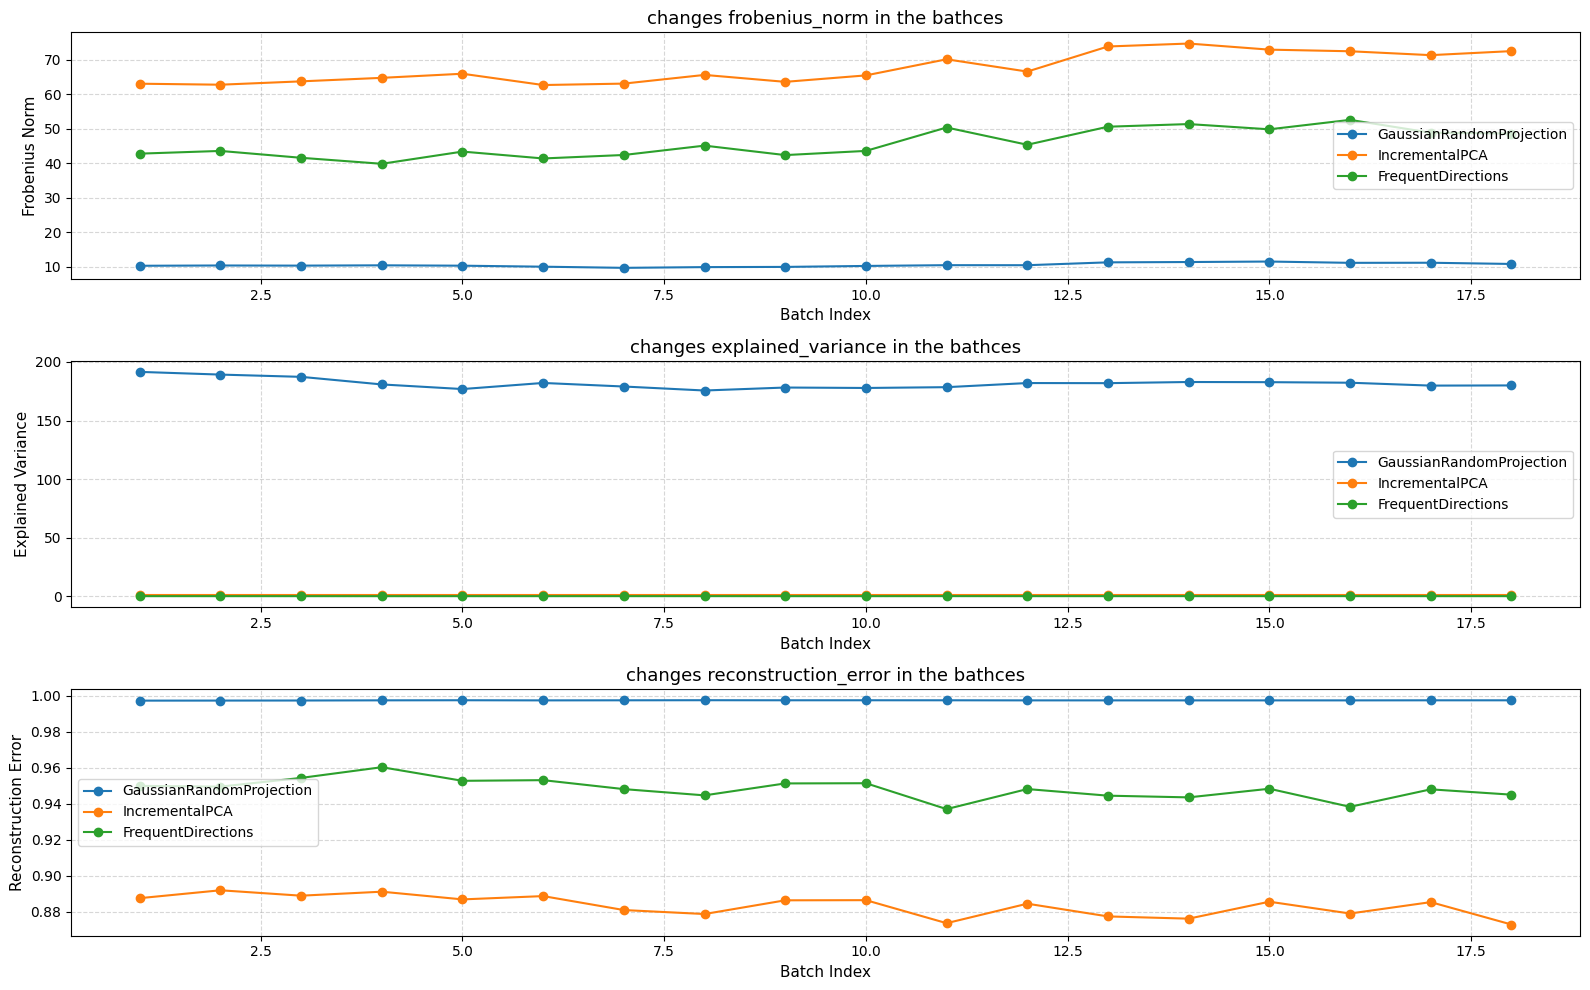

In [27]:
import matplotlib.pyplot as plt

results_df["batch"] = results_df["batch"].astype(int)

metrics = ["frobenius_norm", "explained_variance", "reconstruction_error"]

plt.figure(figsize=(16, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    for alg in results_df["algorithm"].unique():
        subset = results_df[results_df["algorithm"] == alg]
        plt.plot(subset["batch"], subset[metric], marker="o", label=alg)

    plt.title(f"changes {metric} in the bathces", fontsize=13)
    plt.xlabel("Batch Index", fontsize=11)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=11)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
